In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import io
df = pd.read_csv('/content/drive/MyDrive/SCDB_Legacy_01_justiceCentered_Citation.csv',encoding = "ISO-8859-1")


In [ ]:
df.shape

(249793, 61)

In [ ]:
df.head(5)

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,majVotes,minVotes,justice,justiceName,vote,opinion,direction,majority,firstAgreement,secondAgreement
0,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-01,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,1,JJay,1.0,1.0,1.0,2.0,NaN,NaN
1,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-02,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,3,WCushing,1.0,1.0,1.0,2.0,NaN,NaN
2,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-03,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,4,JWilson,1.0,1.0,1.0,2.0,NaN,NaN
3,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-04,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,5,JBlair,1.0,1.0,1.0,2.0,NaN,NaN
4,1791-001,1791-001-01,1791-001-01-01,1791-001-01-01-01-05,8/3/1791,6.0,2 U.S. 401,NaN,1 L. Ed. 433,1791 U.S. LEXIS 189,...,5.0,0.0,6,JIredell,1.0,1.0,1.0,2.0,NaN,NaN


In [ ]:
SCDB_OUTCOME_MAP=None
def get_outcome_map():
    """
    Get the outcome map to convert an SCDB outcome into
    an affirm/reverse/other mapping.

    Rows correspond to vote types.  Columns correspond to disposition types.
    Element values correspond to:
    * -1: no precedential issued opinion or uncodable, i.e., DIGs
    * 0: affirm, i.e., no change in precedent
    * 1: reverse, i.e., change in precent
    """

    # Create map; see appendix of paper for further documentation
    outcome_map = pd.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
    outcome_map.columns = range(1, 12)
    outcome_map.index = range(1, 9)

    return outcome_map
def get_outcome(vote, disposition, outcome_map=SCDB_OUTCOME_MAP):
    """
    Return the outcome code based on outcome map.
    """
    if not outcome_map:
        SCDB_OUTCOME_MAP=get_outcome_map()
        outcome_map = SCDB_OUTCOME_MAP

    if pd.isnull(vote) or pd.isnull(disposition):
        return -1

    return outcome_map.loc[int(vote), int(disposition)]
outcome_map = get_outcome_map()
print(outcome_map)

df.loc[:, "justice_outcome_disposition"] = df.loc[:, ("vote", "caseDisposition")] \
        .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

   1   2   3   4   5   6   7   8   9   10  11
1  -1   0   1   1   1   0   1  -1  -1  -1  -1
2  -1   1   0   0   0   1   0  -1  -1  -1  -1
3  -1   0   1   1   1   0   1  -1  -1  -1  -1
4  -1   0   1   1   1   0   1  -1  -1  -1  -1
5  -1   0   1   1   1   0   1  -1  -1  -1  -1
6  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
7  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
8  -1   0   0   0  -1   0  -1  -1  -1  -1  -1


In [ ]:
df['justice_outcome_disposition'].value_counts()


 0    114780
 1     94505
-1     40508
Name: justice_outcome_disposition, dtype: int64

In [ ]:
df.shape

(249793, 62)

In [ ]:
#Dropping rows or columns with 60% NaN values
perc = 60.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1,
                thresh=min_count)

In [ ]:
#Updated Dataframe shape after dropping rows or columns with 75% NaN values
df.shape

(249793, 51)

In [ ]:
df = df.drop(['decisionType', 'declarationUncon', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration','caseDisposition','vote'],axis=1)

In [ ]:
#Classifying the columns into Categorial and Numerical Columns
data_numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(data_numeric_cols)
print(len(data_numeric_cols))
data_categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(data_categorical_cols)
print(len(data_categorical_cols))

['term', 'naturalCourt', 'petitioner', 'respondent', 'jurisdiction', 'threeJudgeFdc', 'caseOrigin', 'caseSource', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'lawType', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice', 'opinion', 'direction', 'majority', 'justice_outcome_disposition']
30
['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'chief', 'docket', 'caseName', 'dateArgument', 'justiceName']
14


In [ ]:
df.shape

(249793, 44)

In [ ]:
df=df.drop(data_categorical_cols,axis=1)

In [ ]:
shape = df.shape

# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 30


In [ ]:
df.dtypes

term                             int64
naturalCourt                     int64
petitioner                     float64
respondent                     float64
jurisdiction                   float64
threeJudgeFdc                  float64
caseOrigin                     float64
caseSource                     float64
lcDisagreement                 float64
certReason                     float64
lcDisposition                  float64
lcDispositionDirection         float64
voteUnclear                    float64
issue                          float64
issueArea                      float64
decisionDirection              float64
decisionDirectionDissent       float64
authorityDecision1             float64
lawType                        float64
lawSupp                        float64
majOpinWriter                  float64
majOpinAssigner                float64
splitVote                        int64
majVotes                       float64
minVotes                       float64
justice                  

In [ ]:
# It will find zero variance features
from dataclasses import dataclass
from sklearn.feature_selection import VarianceThreshold
varthres = VarianceThreshold(threshold=0)
varthres.fit(df)


VarianceThreshold(threshold=0)

In [ ]:
#This will tell us which columns are zero variance, True value indidcates Non-zero variance column, False value indicates Zero Variance Columns
varthres.get_support()
df.columns[varthres.get_support()]

Index(['term', 'naturalCourt', 'petitioner', 'respondent', 'jurisdiction',
       'threeJudgeFdc', 'caseOrigin', 'caseSource', 'lcDisagreement',
       'certReason', 'lcDisposition', 'lcDispositionDirection', 'voteUnclear',
       'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent',
       'authorityDecision1', 'lawType', 'lawSupp', 'majOpinWriter',
       'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice',
       'opinion', 'direction', 'majority', 'justice_outcome_disposition'],
      dtype='object')

In [ ]:
constant_columns = [column for column in df.columns
                    if column not in df.columns[varthres.get_support()]]

print(len(constant_columns))

0


In [ ]:
# These columns can be dropped
for feature in constant_columns:
  print(feature)

In [ ]:
df=df.drop(constant_columns,axis=1)

In [ ]:
#Updated Dataframe with 36 columns
df.shape

(249793, 30)

<AxesSubplot:>

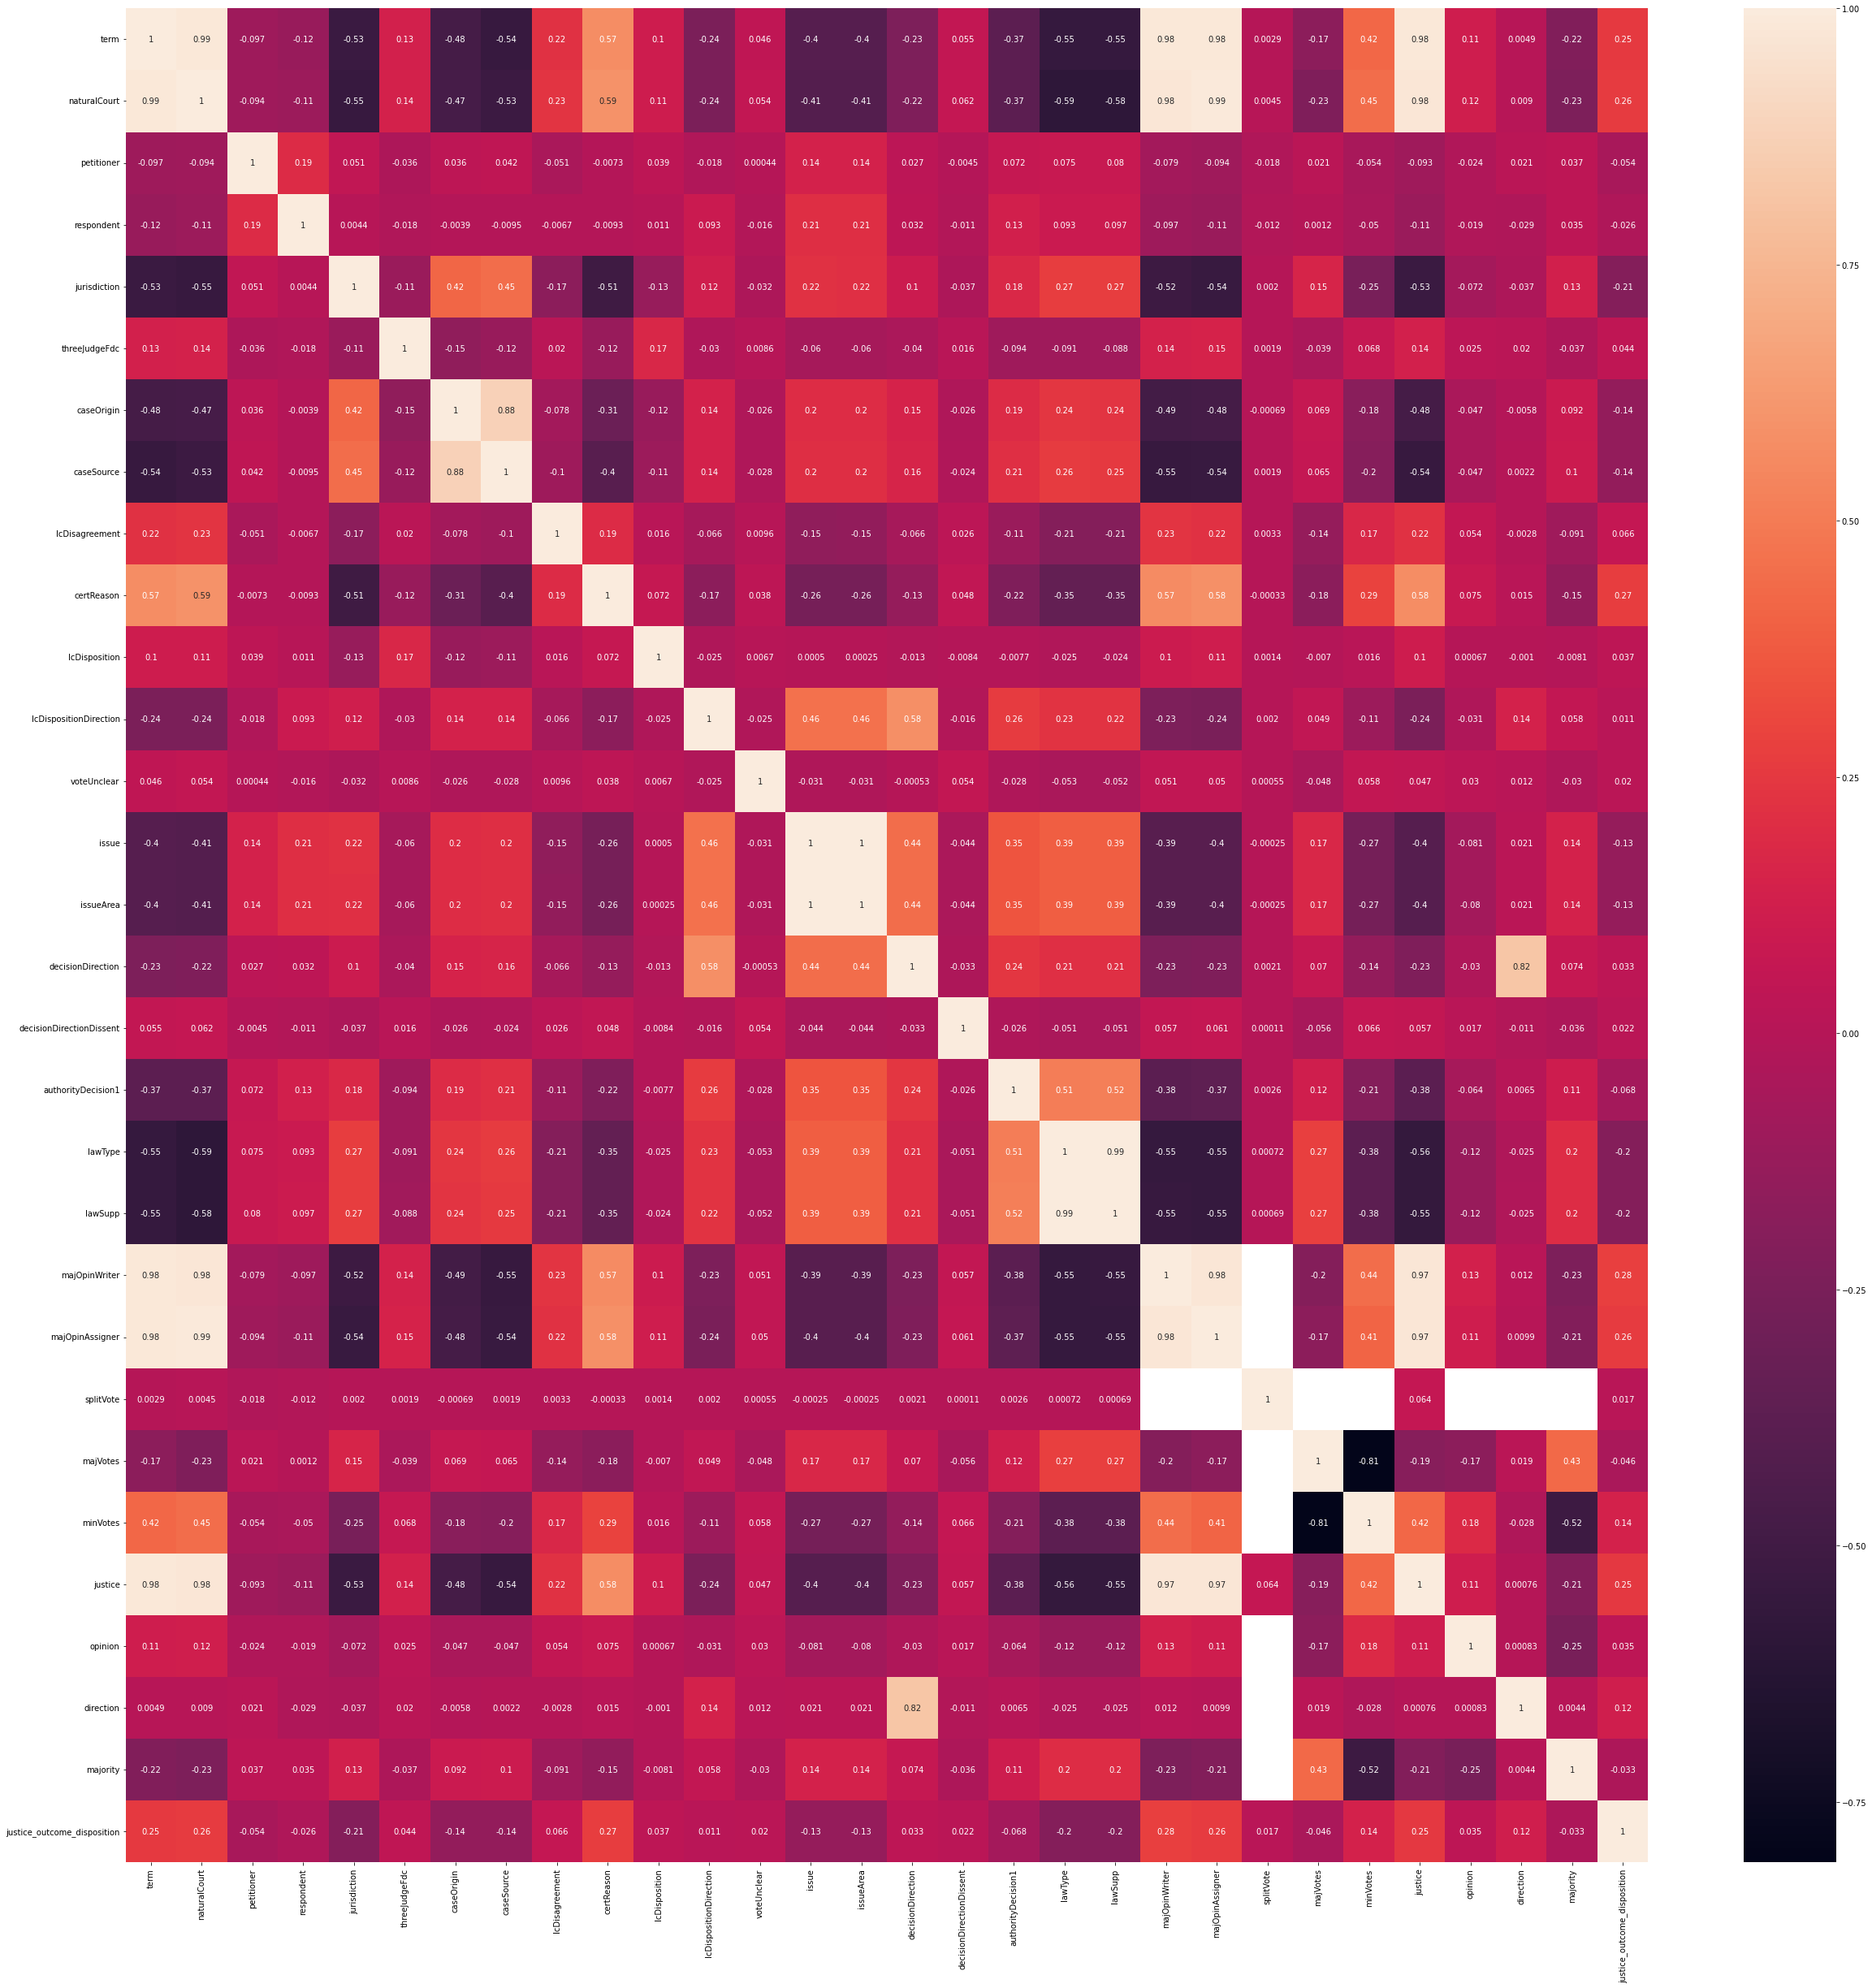

In [ ]:
plt.figure(figsize=(42,42))
sns.heatmap(df.corr(),annot=True)

In [ ]:
#Creating Correlation Matrices

In [ ]:
 #creating a square matrix with dimensions equal to the number of features. In which we will have the elements as the absolute value of correlation between the features.
 cor_matrix = df.corr().abs()
 #Selecting the Upper Triangle Matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

['naturalCourt', 'caseSource', 'issueArea', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'minVotes', 'justice', 'direction']


In [ ]:
#Dropping columns suggested by Matrix Correlation Matrix
df = df.drop(to_drop, axis=1)

In [ ]:
#Updated Dataframe Shape with 32 Columns
df.shape

(249793, 21)

In [ ]:
df['justice_outcome_disposition'].unique()

array([-1,  1,  0])

In [ ]:
df.shape

(249793, 21)

In [ ]:
df['justice_outcome_disposition'].value_counts()

 0    114780
 1     94505
-1     40508
Name: justice_outcome_disposition, dtype: int64

In [ ]:
df.isnull().sum()

term                                0
petitioner                         17
respondent                         36
jurisdiction                        9
threeJudgeFdc                     577
caseOrigin                       8940
lcDisagreement                    223
certReason                        845
lcDisposition                  111022
lcDispositionDirection           9869
voteUnclear                        30
issue                             989
decisionDirection                 764
decisionDirectionDissent          881
authorityDecision1                926
lawType                         11910
splitVote                           0
majVotes                           25
opinion                          8830
majority                        10719
justice_outcome_disposition         0
dtype: int64

In [ ]:
#No need of mapping the data of partyWinning Column because it already holds values 0 &1
df.columns


Index(['term', 'petitioner', 'respondent', 'jurisdiction', 'threeJudgeFdc',
       'caseOrigin', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'voteUnclear', 'issue', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'lawType',
       'splitVote', 'majVotes', 'opinion', 'majority',
       'justice_outcome_disposition'],
      dtype='object')

In [ ]:
df=df.fillna(-1)

In [ ]:
df.shape

(249793, 21)

In [ ]:
df['justice_outcome_disposition'].value_counts()

 0    114780
 1     94505
-1     40508
Name: justice_outcome_disposition, dtype: int64

In [ ]:
raw_data=df.copy()
feature_df=df.copy()
feature_df=feature_df.drop(['justice_outcome_disposition'],axis=1)
raw_data.shape
feature_df.columns

Index(['term', 'petitioner', 'respondent', 'jurisdiction', 'threeJudgeFdc',
       'caseOrigin', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'voteUnclear', 'issue', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'lawType',
       'splitVote', 'majVotes', 'opinion', 'majority'],
      dtype='object')

In [ ]:
raw_data.isnull().sum()

term                           0
petitioner                     0
respondent                     0
jurisdiction                   0
threeJudgeFdc                  0
caseOrigin                     0
lcDisagreement                 0
certReason                     0
lcDisposition                  0
lcDispositionDirection         0
voteUnclear                    0
issue                          0
decisionDirection              0
decisionDirectionDissent       0
authorityDecision1             0
lawType                        0
splitVote                      0
majVotes                       0
opinion                        0
majority                       0
justice_outcome_disposition    0
dtype: int64

In [ ]:
term_range = range(raw_data["term"].min() + 25,
                   raw_data["term"].max() + 1)
count=0

for term in term_range:
  count=count+1
  train_index = (raw_data.loc[:, "term"] < term).values
  test_index = (raw_data.loc[:, "term"] == term).values
  if test_index.sum() == 0:
        continue
  feature_data_train = feature_df.loc[train_index, :]
  target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
  feature_data_test = feature_df.loc[test_index, :]
  target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
  rf = RandomForestClassifier(n_estimators = 9,max_depth=8 ,random_state = 42,criterion='entropy')
  rf.fit(feature_data_train, target_data_train);
  raw_data.loc[test_index, "rf_predicted"] = rf.predict(feature_data_test)
  print(term)

  evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
print(classification_report(target_actual, target_predicted))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

term_range = range(raw_data["term"].min() + 25,
                   raw_data["term"].max() + 1)
count=0

for term in term_range:
  count=count+1
  train_index = (raw_data.loc[:, "term"] < term).values
  test_index = (raw_data.loc[:, "term"] == term).values
  if test_index.sum() == 0:
        continue
  feature_data_train = feature_df.loc[train_index, :]
  target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
  feature_data_test = feature_df.loc[test_index, :]
  target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
  knn =KNeighborsClassifier(n_neighbors=10)
  knn.fit(feature_data_train, target_data_train);
  raw_data.loc[test_index, "rf_predicted"] = knn.predict(feature_data_test)
  print(term)

  evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
print(classification_report(target_actual, target_predicted))


In [ ]:
from sklearn.naive_bayes import GaussianNB
term_range = range(raw_data["term"].min() + 25,
                   raw_data["term"].max() + 1)
count=0

for term in term_range:
  count=count+1
  train_index = (raw_data.loc[:, "term"] < term).values
  test_index = (raw_data.loc[:, "term"] == term).values
  if test_index.sum() == 0:
        continue
  feature_data_train = feature_df.loc[train_index, :]
  target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
  feature_data_test = feature_df.loc[test_index, :]
  target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
  gnb = GaussianNB()
  gnb.fit(feature_data_train, target_data_train);
  raw_data.loc[test_index, "rf_predicted"] = gnb.predict(feature_data_test)
  print(term)

  evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
print(classification_report(target_actual, target_predicted))


In [ ]:
from sklearn.linear_model import LogisticRegression
term_range = range(raw_data["term"].min() + 25,
                   raw_data["term"].max() + 1)
count=0

for term in term_range:
  count=count+1
  train_index = (raw_data.loc[:, "term"] < term).values
  test_index = (raw_data.loc[:, "term"] == term).values
  if test_index.sum() == 0:
        continue
  feature_data_train = feature_df.loc[train_index, :]
  target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
  feature_data_test = feature_df.loc[test_index, :]
  target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
  clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  clf.fit(feature_data_train, target_data_train);
  raw_data.loc[test_index, "rf_predicted"] = clf.predict(feature_data_test)
  print(term)

  evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
print(classification_report(target_actual, target_predicted))
